In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment.

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`).

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [2]:
import pandas as pd

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [ ]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url, parse_dates=['Inspection Date'])
df.set_index(keys='Inspection Date', inplace=True)
# YOUR CODE HERE


**Task 1 Test**

In [ ]:
'''T1 Test'''


assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [ ]:
'''T2. Identify data leakage column.'''


leaky_col = 'Fail'
# YOUR CODE HERE
#serious violations found

In [ ]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Type',
       'Violations', 'Latitude', 'Longitude', 'Location', 'Fail',
       'Serious Violations Found'],
      dtype='object')

**Task 2 Test**

In [ ]:
'''T2 Test'''
# This is a hidden test.
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [ ]:
'''T3. Write wrangle function.'''
def wrangle(df):

  # highcardcutoff = 500
  # drop_cols = [col for col in df.columns if (df[col].nunique() > highcardcutoff)]

  # df.drop(columns=drop_cols, inplace=True)

  #drop leaky and state (it's all in chicago) and ID
  df.drop(columns=['State', 'City'], inplace=True)

  #df.drop(columns=['Fail'], inplace=True)
  df.sort_index(axis=1, inplace=True)
  return df

# YOUR CODE HERE

df = wrangle(df)

In [ ]:
df.head()

,AKA Name,Address,DBA Name,Facility Type,Fail,Inspection ID,Inspection Type,Latitude,License #,Location,Longitude,Risk,Serious Violations Found,Violations,Zip
Inspection Date,,,,,,,,,,,,,,,
2017-09-15,TOM YUM CAFE,608 W BARRY,"TOM YUM RICE & NOODLE, INC.",Restaurant,1,2088270,Canvass,41.938007,2354911.0,"{'longitude': '-87.6447545707008', 'latitude':...",-87.644755,Risk 1 (High),2.0,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,60657.0
2011-10-20,FILLING STATION & CONVENIENCE STORE,6646-6658 S WESTERN AVE,FILLING STATION & CONVENIENCE STORE,Grocery Store,0,555268,Complaint Re-Inspection,41.772402,1044901.0,"{'longitude': '-87.68360273081268', 'latitude'...",-87.683603,Risk 3 (Low),0.0,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,60636.0
2016-04-05,A P DELI,2025 E 75TH ST,A P DELI,Restaurant,0,1751394,Canvass Re-Inspection,41.758779,47405.0,"{'longitude': '-87.57505446746121', 'latitude'...",-87.575054,Risk 1 (High),0.0,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",60649.0
2016-04-29,FRANK'S CHICAGO SHRIMP HOUSE,4459 S ARCHER AVE,FRANK'S CHICAGO SHRIMP HOUSE,Restaurant,0,1763905,Canvass,41.812181,6414.0,"{'longitude': '-87.70712481334274', 'latitude'...",-87.707125,Risk 2 (Medium),0.0,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,60632.0
2011-01-10,MORRILL,6011 S Rockwell (2600W) AVE,MORRILL,School,0,453326,Canvass,NaN,24571.0,NaN,NaN,Risk 1 (High),0.0,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",60629.0


In [ ]:
#checking cardinality of cols for encoding or dropping
df['Inspection Type'].nunique()

51

In [ ]:
df['Facility Type'].nunique()

329

**Task 3 Test**

In [ ]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

AssertionError: ignored

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [ ]:
'''T4. Split feature matrix and target vector.'''
y = df['Fail']
X = df.drop(columns='Fail')
# YOUR CODE HERE


**Task 4 Test**

In [ ]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [ ]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE

cutoff = '2017-01-01'
train = df[df.index < cutoff]
val = df[df.index > cutoff]

#Split into respective train-test sets

X_train = train.drop(columns=leaky_col)
y_train = train[leaky_col]
X_val = val.drop(columns=leaky_col)
y_val = val[leaky_col]


In [ ]:
y_train

**Task 5 Testing**

In [ ]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [ ]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
print(y_train.value_counts(normalize=True))
baseline_acc = 0.75
print('Baseline accuracy:', baseline_acc)

**Task 6 Testing**

In [ ]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [ ]:
!pip install category_encoders
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [ ]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE
#ordinalencoder for categorical features
model_bag = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)
)

# Fit on train, score on val
model_bag.fit(X_train, y_train)
print('Val Accuracy:', model_bag.score(X_val, y_val))
model_bag.fit(X_train, y_train);

Val Accuracy: 0.8790762216275151


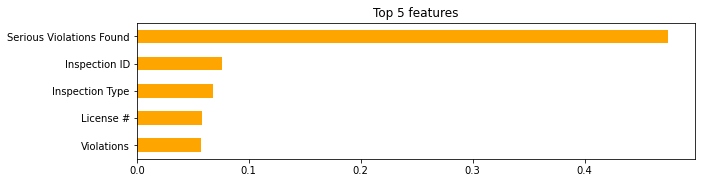

In [ ]:
# feature importances
rf = model_bag.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='orange');

In [ ]:
column  = ['Risk','Facility Type', 'Zip']

# Fit without Risk
bag2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)
)
bag2.fit(X_train.drop(columns=column), y_train)
score_without = bag2.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with Risk
bag3 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)
)
bag3.fit(X_train, y_train)
score_with = bag3.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without ['Risk', 'Facility Type', 'Zip']: 0.7992863514719001
Validation Accuracy with ['Risk', 'Facility Type', 'Zip']: 0.8790762216275151
Drop-Column Importance for ['Risk', 'Facility Type', 'Zip']: 0.079789870155615


**Tast 7 Testing**

In [ ]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary.

In [ ]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
from xgboost import XGBClassifier
model_boost = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=75, n_jobs=-1)
)

model_boost.fit(X_train, y_train)
model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [ ]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [ ]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9999521839959834
Validation accuracy: 0.8790762216275151

Boosting Model
Training accuracy: 0.9112295885432854
Validation accuracy: 0.8800674001387649


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

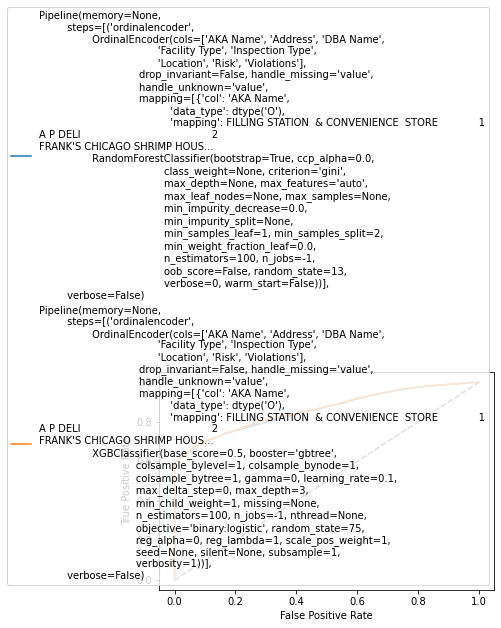

In [ ]:
'''T9. Plot ROC-curve.'''
# YOUR CODE HERE
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

curve_1 = plot_roc_curve(model_bag, X_val, y_val, label=model_bag)

curve_2 = plot_roc_curve(model_boost, X_val, y_val, label=model_boost, ax=curve_1.ax_)
plt.plot([(0,0), (1,1)], color='grey', linestyle='--');



**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`.

In [ ]:
y_pred = model_bag.predict(X_val)
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
'''T10. Generate classification report for one model.'''

# YOUR CODE HERE
model_cr = classification_report(y_val, y_pred, target_names=['Pass', 'Fail'])
print(model_cr)

              precision    recall  f1-score   support

        Pass       0.85      1.00      0.92      7092
        Fail       1.00      0.59      0.74      2997

    accuracy                           0.88     10089
   macro avg       0.93      0.80      0.83     10089
weighted avg       0.90      0.88      0.87     10089



**Task 10 Testing**

In [ ]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [ ]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE
from sklearn.inspection import permutation_importance

# r = permutation_importance(model_bag, X_val, y_val,
#                            n_repeats=30,
#                            random_state=13)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{X_val.columns[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")


results = permutation_importance(model_boost, X_val, y_val,
                                n_repeats=5, random_state=42,
                                n_jobs=-1)

data = {'importances_mean': results['importances_mean'],
       'importances_std': results['importances_std']}
permutation_importances = pd.DataFrame(data, index=X_val.columns)
permutation_importances.sort_values('importances_mean',
                                  ascending=False,
                                  inplace=True)

permutation_importances

,importances_mean,importances_std
Serious Violations Found,0.248508,0.001713
Facility Type,0.000020,0.000040
Zip,0.000020,0.000040
AKA Name,0.000000,0.000000
Address,0.000000,0.000000
DBA Name,0.000000,0.000000
Inspection ID,0.000000,0.000000
Inspection Type,0.000000,0.000000
Latitude,0.000000,0.000000
License #,0.000000,0.000000


In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

permutation_importances = PermutationImportance(model_boost).fit(X_val, y_val)
eli5.show_weights(perm)

ValueError: ignored

**Task 11 Testing**

In [ ]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

AssertionError: ignored

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

In [ ]:
!pip install pdpbox

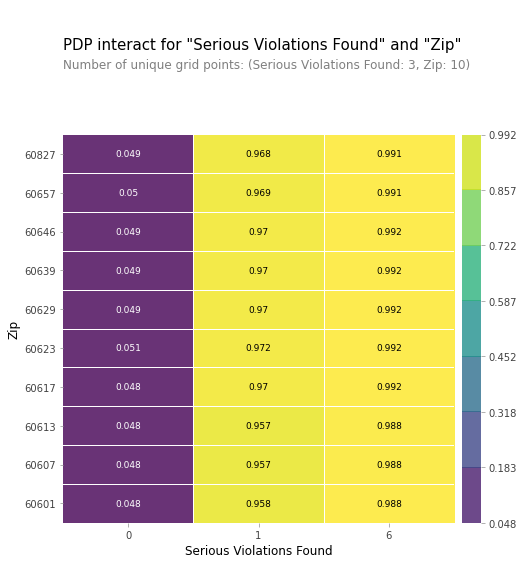

In [ ]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''


# YOUR CODE HERE
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# Create the plot for a single feature isolated

#isolated = pdp_isolate(
#    model= model_boost,
#    dataset=X_val.dropna(),
#    model_features=X_val.columns,
#    feature=features
#)



# Uncomment the next line to create your own plot
#pdp_plot(isolated, feature_name=features);

features = ['Serious Violations Found',
       'Zip']


interact = pdp_interact(
    model=model_boost,
    dataset=X_val.dropna(),
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

plt.show()

What do you think? Is there a relationship between location and failing a food saftey inspection?

In [ ]:
X_val.columns

Index(['AKA Name', 'Address', 'DBA Name', 'Facility Type', 'Inspection ID',
       'Inspection Type', 'Latitude', 'License #', 'Location', 'Longitude',
       'Risk', 'Serious Violations Found', 'Violations', 'Zip'],
      dtype='object')

In [ ]:
X_val.head()

,AKA Name,Address,DBA Name,Facility Type,Inspection ID,Inspection Type,Latitude,License #,Location,Longitude,Risk,Serious Violations Found,Violations,Zip
Inspection Date,,,,,,,,,,,,,,
2017-09-15,TOM YUM CAFE,608 W BARRY,"TOM YUM RICE & NOODLE, INC.",Restaurant,2088270,Canvass,41.938007,2354911.0,"{'longitude': '-87.6447545707008', 'latitude':...",-87.644755,Risk 1 (High),2.0,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,60657.0
2017-01-12,GOLD COAST DOGS,225 S CANAL ST,GOLD COAST DOGS,Restaurant,1981372,Canvass,41.878531,32318.0,"{'longitude': '-87.63942745962717', 'latitude'...",-87.639427,Risk 2 (Medium),0.0,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",60606.0
2017-02-10,MARK TWAIN ELEMENTARY,5134 S LOTUS,MARK TWAIN ELEMENTARY,School,1982990,Canvass Re-Inspection,41.799052,25661.0,"{'longitude': '-87.75896524463428', 'latitude'...",-87.758965,Risk 1 (High),NaN,NaN,60638.0
2017-08-01,VICEROY HOTEL,1118 N STATE ST,VICEROY HOTEL,Liquor,2071751,License,41.902312,2535449.0,"{'longitude': '-87.62849738136275', 'latitude'...",-87.628497,Risk 3 (Low),NaN,NaN,60610.0
2018-10-31,MILD 2 SPICY,714 W DIVERSEY PKWY,MILD2 SPICY,Restaurant,2232615,Complaint,41.932864,2536509.0,"{'longitude': '-87.64724608217887', 'latitude'...",-87.647246,Risk 1 (High),0.0,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60614.0


In [ ]:
y_pred_prob = model_boost.predict_proba(X_val)[:,1]

In [ ]:
predictions = pd.DataFrame(data=y_pred_prob)


In [ ]:
predictions

,0
0,0.997460
1,0.021993
2,0.003551
3,0.187487
4,0.111152
...,...
10084,0.992195
10085,0.190204
10086,0.044059
10087,0.033133


In [ ]:
train.columns

Index(['AKA Name', 'Address', 'DBA Name', 'Facility Type', 'Fail',
       'Inspection ID', 'Inspection Type', 'Latitude', 'License #', 'Location',
       'Longitude', 'Risk', 'Serious Violations Found', 'Violations', 'Zip'],
      dtype='object')

In [ ]:
df.columns

Index(['AKA Name', 'Address', 'DBA Name', 'Facility Type', 'Fail',
       'Inspection ID', 'Inspection Type', 'Latitude', 'License #', 'Location',
       'Longitude', 'Risk', 'Serious Violations Found', 'Violations', 'Zip'],
      dtype='object')

LinAlgError: ignored

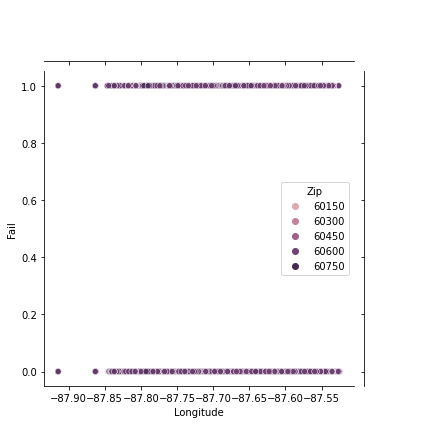

In [ ]:

import seaborn as sns
sns.jointplot(data=df, x='Longitude', y="Fail", hue="Zip");

In [ ]:
BBox = ((df.Longitude.min(),  df.Longitude.max(),
         df.Latitude.min(), df.Latitude.max()))
BBox


(-87.91442843927048, -87.5250941359867, 41.644670132198044, 42.02106424782547)

In [ ]:
ruh_m = plt.imread('/content/map.png')


In [ ]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')